In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr

In [286]:
import icl_draw
reload(icl_draw)
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle

In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap1 = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']
gal1s = pklload("./database/01_nh_ghmatch.pickle")
hal1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp)

# mode = 'nh2'
# iout = 797
# repo, rurmode, dp = mode2repo(mode)
# snap2 = uri.RamsesSnapshot(repo, iout, mode=rurmode)
# snap2s = uri.TimeSeries(snap2)
# snap2s.read_iout_avail()
# nout2 = snap2s.iout_avail['iout']
# gal2s = pklload("./database/01_nh2_ghmatch.pickle")
# hal2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp)

result1s = pklload(f"./database/03_MWA1s.pickle")
# result2s = pklload(f"./database/03_MWA2s.pickle")
pair1s = pklload(f"./database/06_nh_subhalo_pairs.pickle")
# pair2s = pklload(f"./database/06_nh2_subhalo_pairs.pickle")
scores = pklload(f"./database/08_nh_scores.pickle")

cols = [
    "Host", "Sat", "r50m", "r90m", "r50r", "r90r", 
    "SFR_mem", "u_mem", "g_mem", "r_mem", "i_mem", "z_mem", "metal_mem", "ager_mem", "t50_mem", "t90_mem"] 
category = ["r50m", "r90m", "r50r", "r90r", "rmax"]


for icate in category:
    cols = cols+[f"SFR_{icate}", f"u_{icate}", f"g_{icate}", f"r_{icate}", f"i_{icate}", f"z_{icate}", f"metal_{icate}", f"ager_{icate}", f"t50_{icate}", f"t90_{icate}", f"mgas_{icate}", f"mcold_{icate}", f"mdm_{icate}"]

dtype = [(col, np.float64) for col in cols]
print(len(dtype))
dtype[0] = ("Host", np.int32)
dtype[1] = ("Sat", np.int32)
dtype = np.dtype(dtype)

vad = np.genfromtxt("./database/09_value_added.txt", delimiter="\t", dtype=dtype, skip_header=1)

81


In [238]:
dm_scores = pklload("./database/08_nh_dm_scores.pickle")

In [372]:
result1s['id']

array([   1,    2,    3,    4,    7,    8,    9,   10,   11,   14,   17,
         19,   20,   21,   23,   24,   25,   26,   29,   35,   36,   37,
         40,   41,   46,   47,   52,   54,   60,   63,   64,   65,   66,
         68,   75,   84,   91,   92,  104,  107,  108,  121,  129,  133,
        136,  148,  165,  168,  207,  212,  937, 1252, 1545, 1920],
      dtype=int32)

In [240]:
target_id = 1
MWA = result1s[0]
target_hid = MWA['halo_id']
pairs = pair1s[1]

gal_gives = scores['give'][1]
gal_takes = scores['take'][1]
hal_gives = dm_scores['give'][1]
hal_takes = dm_scores['take'][1]

star = uri.Particle(pklload(f"./database/parts/nh_star_{target_id:04d}.pickle"), snap1 )
dm = uri.Particle(pklload(f"./database/parts/nh_dm_{target_id:04d}.pickle"), snap1 )
cell = uri.Cell(pklload(f"./database/parts/nh_cell_{target_id:04d}.pickle"), snap1 )

In [198]:
values = vad[vad['Host'] == target_id]
values['Sat']

array([ 178,  220,  226,  290,  510,  575,  606, 1115, 1116, 1117, 1118,
       1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129,
       1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140,
       1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151,
       1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162,
       1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173,
       1174, 1175, 1176, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972,
       2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983,
       2984, 2985, 2986, 3069, 3070, 3071, 3072, 3073, 3074], dtype=int32)

In [24]:
rband = measure_luminosity(star, 'SDSS_r')
starmap = painter.partmap(star, box=snap1.box, weights=rband, shape=1080)
cellmap = painter.gasmap(cell, box=snap1.box, shape=1080)

In [78]:
dmmap_raw = painter.partmap(dm, box=snap1.box, shape=1080)

In [221]:
dmmap = gaussian_filter(dmmap_raw, sigma=5)

# Figure Drawing

## All sub

In [311]:
cmap_star = drawer.make_cmap([(0,0,0),(1,0,0),(1,1,0),(1,1,1)], position=[0,0.4,0.8,1])
composite = painter.composite_image(
    [cellmap, dmmap], 
    cmaps=[cmr.neutral, cmr.jungle],
    qscales=[4,2.5],
    mode='screen',
    vmaxs = [np.nanmax(cellmap)*10, np.nanmax(dmmap)*1.2]
    )

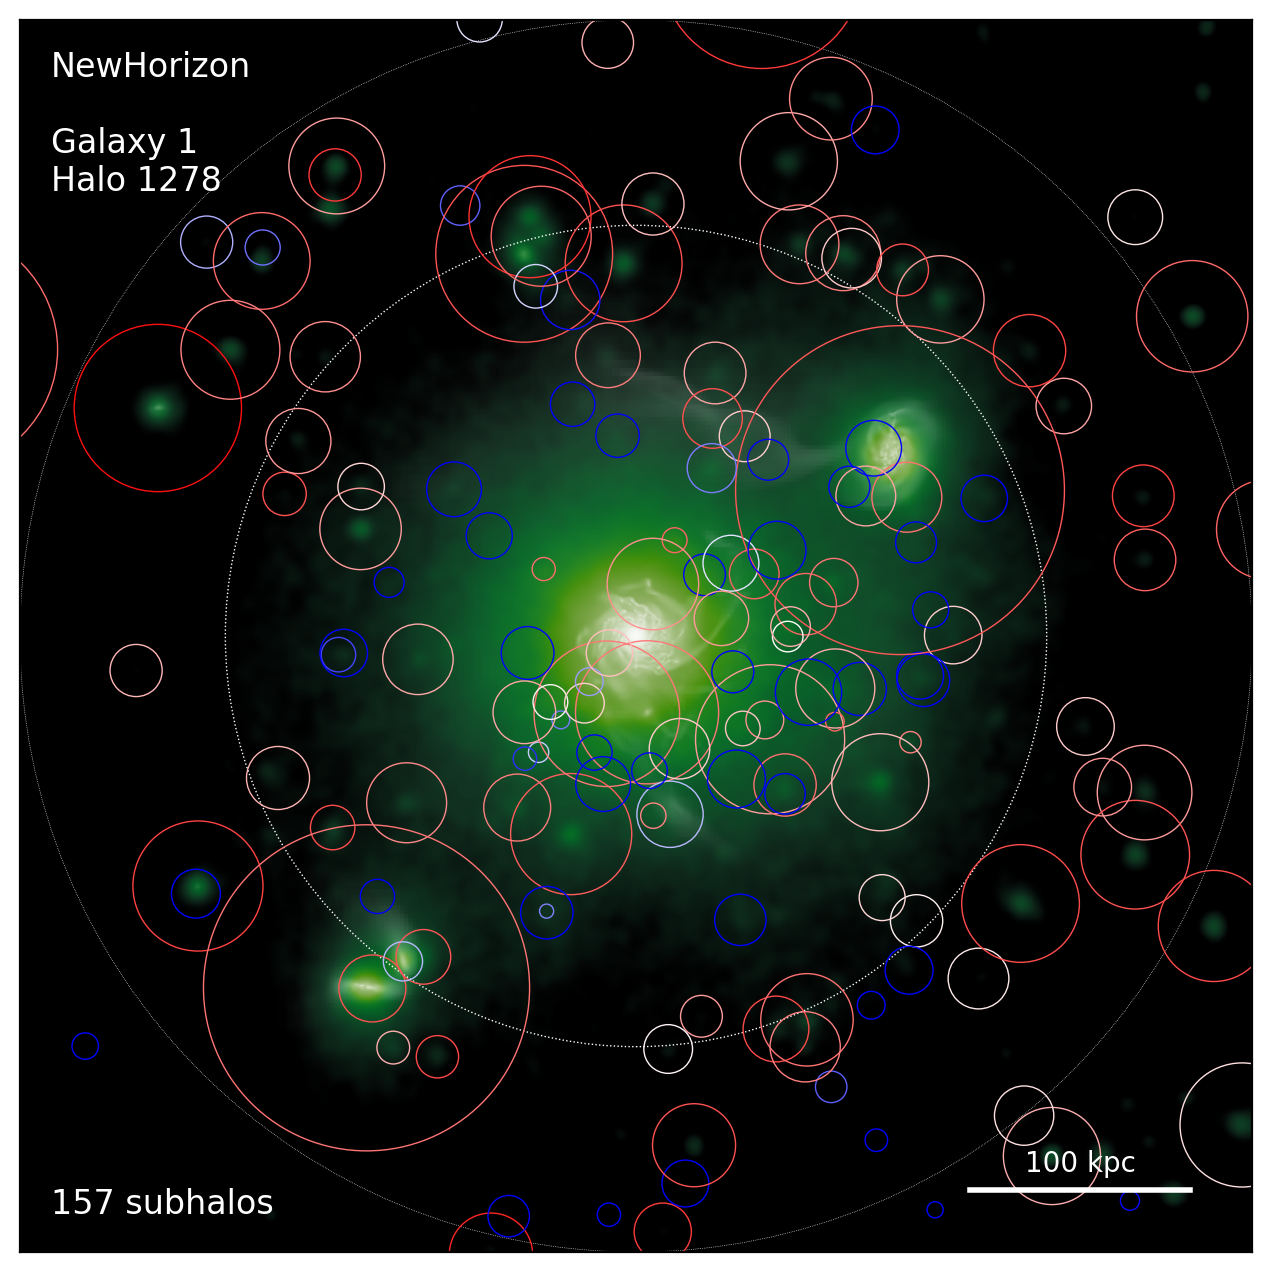

In [312]:
fig, ax = fancy_axis(figsize=(8,8), dpi=200)

snap1.set_box_halo(MWA, 1.5, radius_name='r200_code')
ax.imshow(composite, origin='lower', extent=snap1.box[:2].flatten(), aspect='equal')
cir = plt.Circle((MWA['halo_x'], MWA['halo_y']), MWA['r200_code'], color='w', fill=False, lw=0.5, ls=':')
ax.add_artist(cir)
cir = plt.Circle((MWA['halo_x'], MWA['halo_y']), 1.5*MWA['r200_code'], color='w', fill=False, lw=0.25, ls=':')
ax.add_artist(cir)
cmap = plt.cm.bwr
norm = plt.Normalize(vmin=0, vmax=1)

nhalo = 0
for hkey in hal_takes.keys():
    if(hkey == MWA['halo_id']): continue
    sub = hal1s[hkey-1]
    take_scos = hal_takes[hkey]
    take_sco = 2 * np.median(take_scos%1)
    # if(take_sco < 0.3): continue
    cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color=cmap(norm(take_sco)), fill=False, lw=0.5, ls='-')
    ax.add_artist(cir)
    nhalo += 1

add_scalebar(ax, snap1.unit_l)
addtext(f"{nhalo} subhalos",ax=ax, loc='lower left', color='white', fontsize=12, offset=0.025)
addtext(f"NewHorizon\n\nGalaxy {target_id}\nHalo {target_hid}",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025)

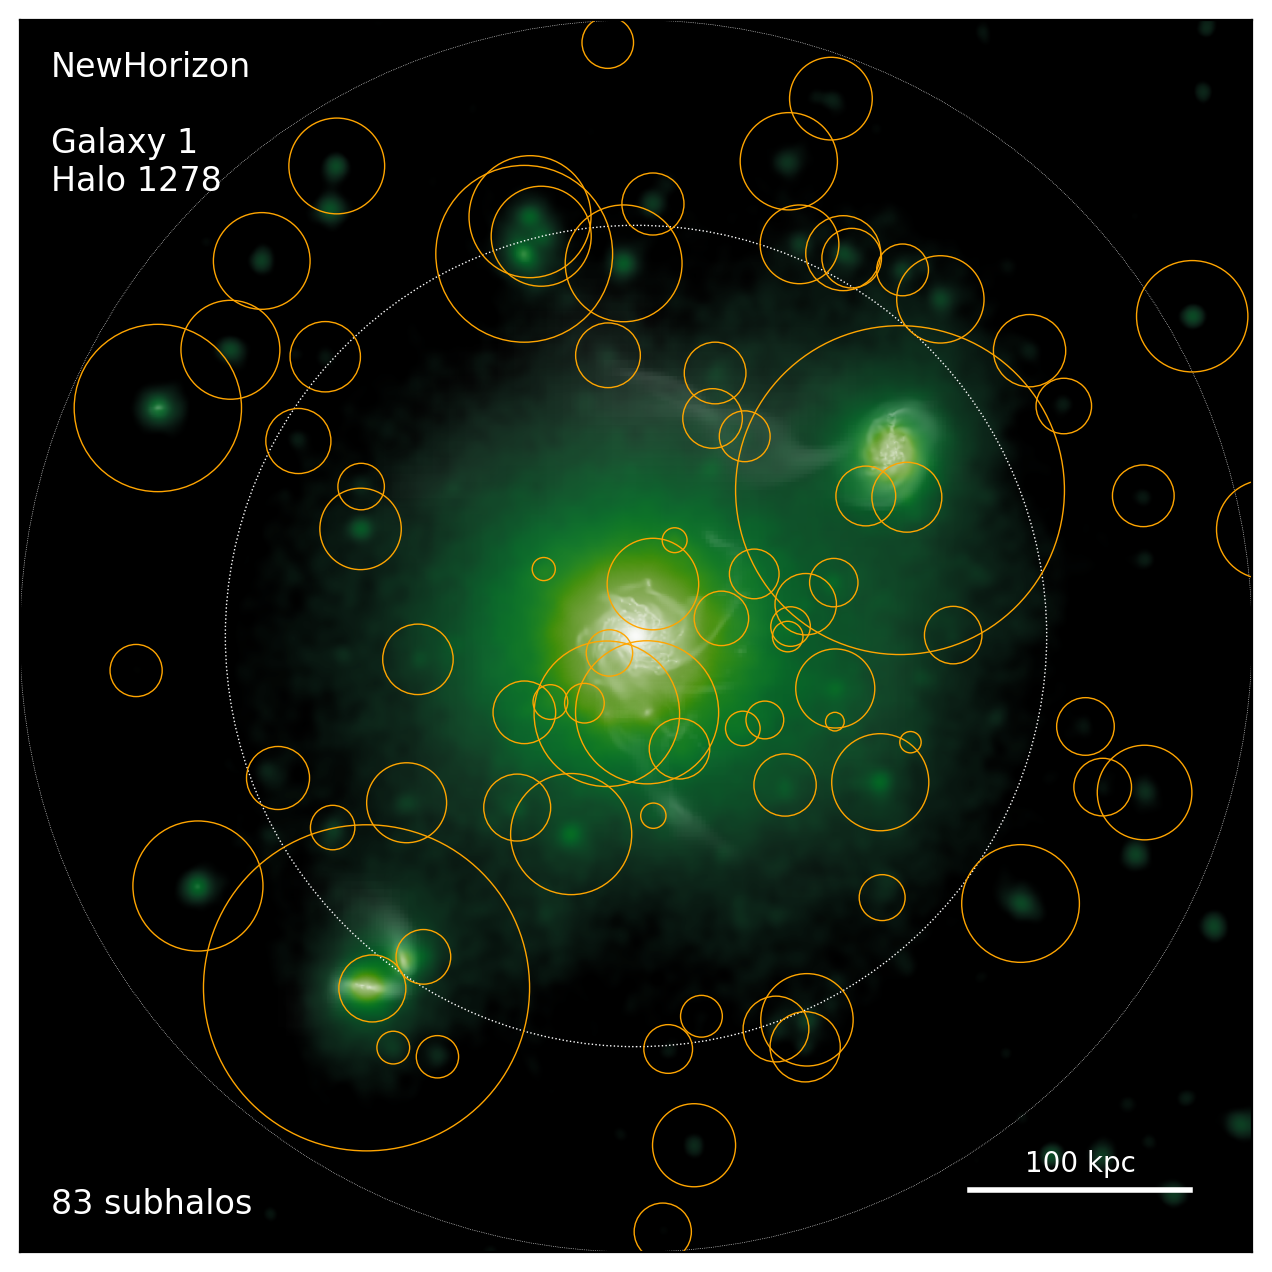

In [313]:
fig, ax = fancy_axis(figsize=(8,8), dpi=200)

snap1.set_box_halo(MWA, 1.5, radius_name='r200_code')
ax.imshow(composite, origin='lower', extent=snap1.box[:2].flatten(), aspect='equal')
cir = plt.Circle((MWA['halo_x'], MWA['halo_y']), MWA['r200_code'], color='w', fill=False, lw=0.5, ls=':')
ax.add_artist(cir)
cir = plt.Circle((MWA['halo_x'], MWA['halo_y']), 1.5*MWA['r200_code'], color='w', fill=False, lw=0.25, ls=':')
ax.add_artist(cir)
cmap = plt.cm.bwr
norm = plt.Normalize(vmin=0, vmax=1)

nhalo = 0
realsubs = None
for hkey in hal_takes.keys():
    if(hkey == MWA['halo_id']): continue
    sub = hal1s[hkey-1]
    dist = distance(sub, MWA['halo_x'], MWA['halo_y'], MWA['halo_z'])
    if(dist > (1.5*MWA['r200_code'] + sub['rvir'])): continue
    take_scos = hal_takes[hkey]
    take_sco = 2 * np.median(take_scos%1)
    if(take_sco < 0.5): continue
    cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color='tomato', fill=False, lw=0.5, ls='-')
    ax.add_artist(cir)
    nhalo += 1
    realsubs = sub if(realsubs is None) else np.hstack((realsubs, sub))

add_scalebar(ax, snap1.unit_l)
addtext(f"{nhalo} subhalos",ax=ax, loc='lower left', color='white', fontsize=12, offset=0.025)
addtext(f"NewHorizon\n\nGalaxy {target_id}\nHalo {target_hid}",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025)

## All sat

In [314]:
cmap_star = drawer.make_cmap([(0,0,0),(1,0,0),(1,1,0),(1,1,1)], position=[0,0.4,0.8,1])
composite = painter.composite_image(
    [starmap, cellmap], 
    cmaps=[cmap_star, cmr.neutral],
    qscales=[4.5,4],
    mode='screen',
    vmaxs = [np.nanmax(starmap)*0.9, np.nanmax(cellmap)*10]
    )

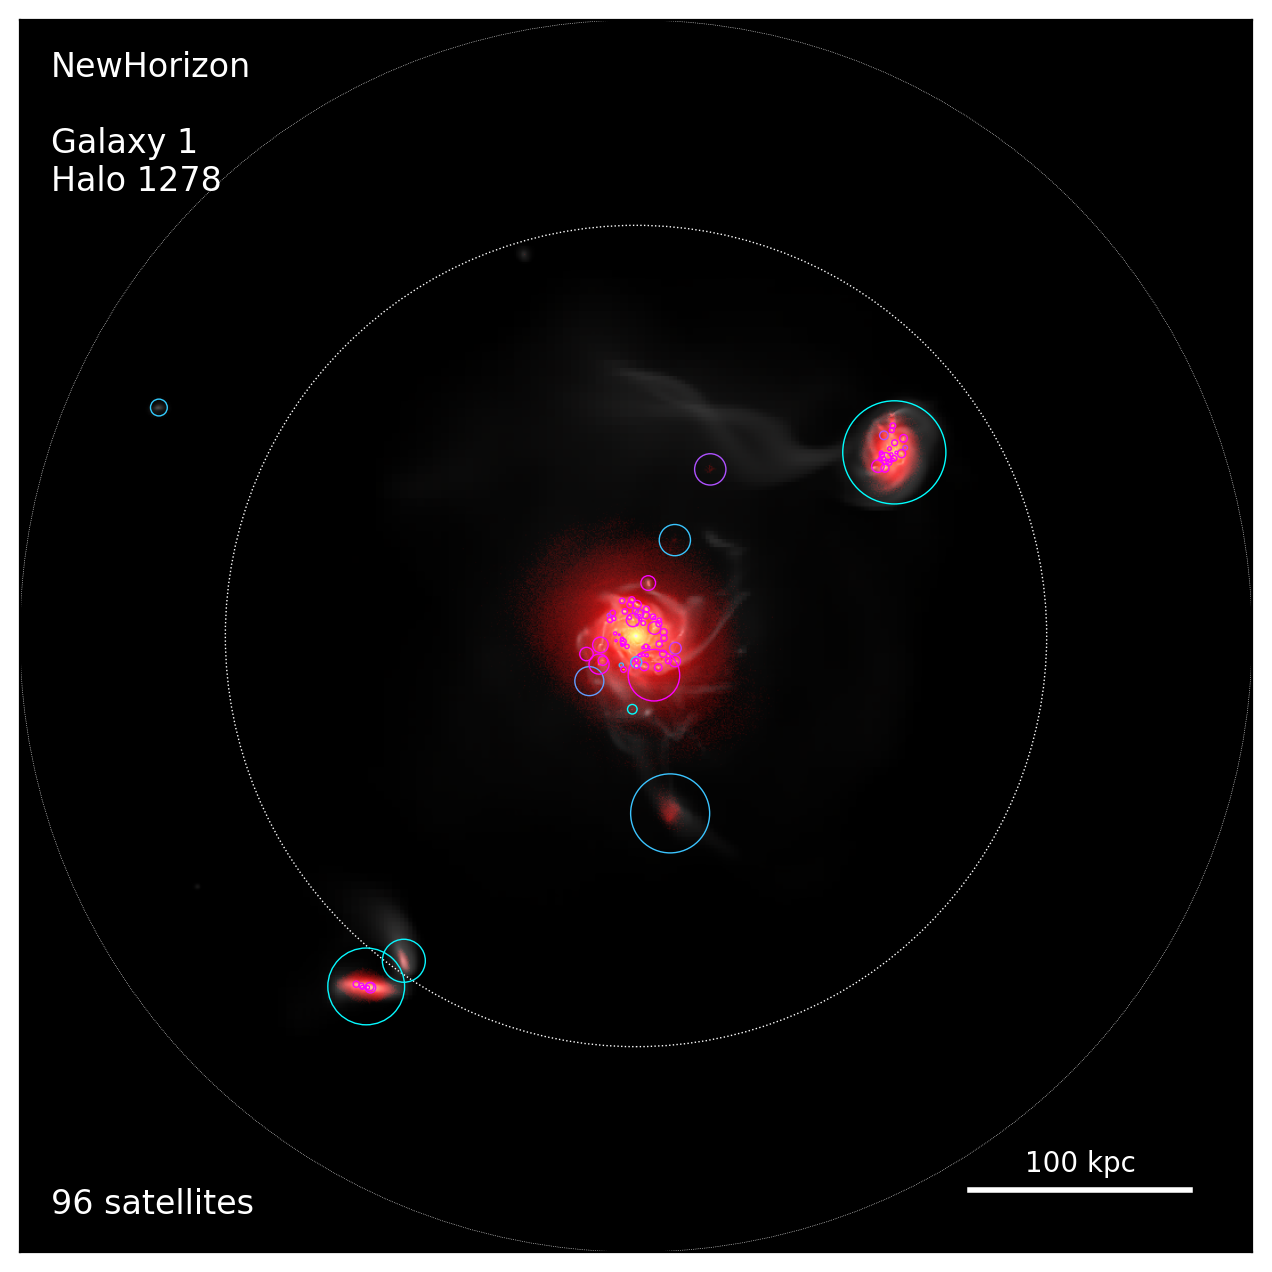

In [315]:
fig, ax = fancy_axis(figsize=(8,8), dpi=200)

snap1.set_box_halo(MWA, 1.5, radius_name='r200_code')
ax.imshow(composite, origin='lower', extent=snap1.box[:2].flatten(), aspect='equal')
cir = plt.Circle((MWA['halo_x'], MWA['halo_y']), MWA['r200_code'], color='w', fill=False, lw=0.5, ls=':')
ax.add_artist(cir)
cir = plt.Circle((MWA['halo_x'], MWA['halo_y']), 1.5*MWA['r200_code'], color='w', fill=False, lw=0.25, ls=':')
ax.add_artist(cir)
cmap = plt.cm.cool_r
norm = plt.Normalize(vmin=0, vmax=1)

ngal = 0
for val in values:
    if(not val['Sat'] in gal_takes.keys()): continue
    take_scos = gal_takes[val['Sat']]
    take_sco = 2 * np.median(take_scos%1)
    sat = gal1s[val['Sat']-1]
    # if(take_sco < 0.5): continue
    cir = plt.Circle((sat['x'], sat['y']), sat['r'], color=cmap(norm(take_sco)), fill=False, lw=0.5, ls='-')
    ax.add_artist(cir)
    ngal += 1

add_scalebar(ax, snap1.unit_l)
addtext(f"{ngal} satellites",ax=ax, loc='lower left', color='white', fontsize=12, offset=0.025)
addtext(f"NewHorizon\n\nGalaxy {target_id}\nHalo {target_hid}",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025)

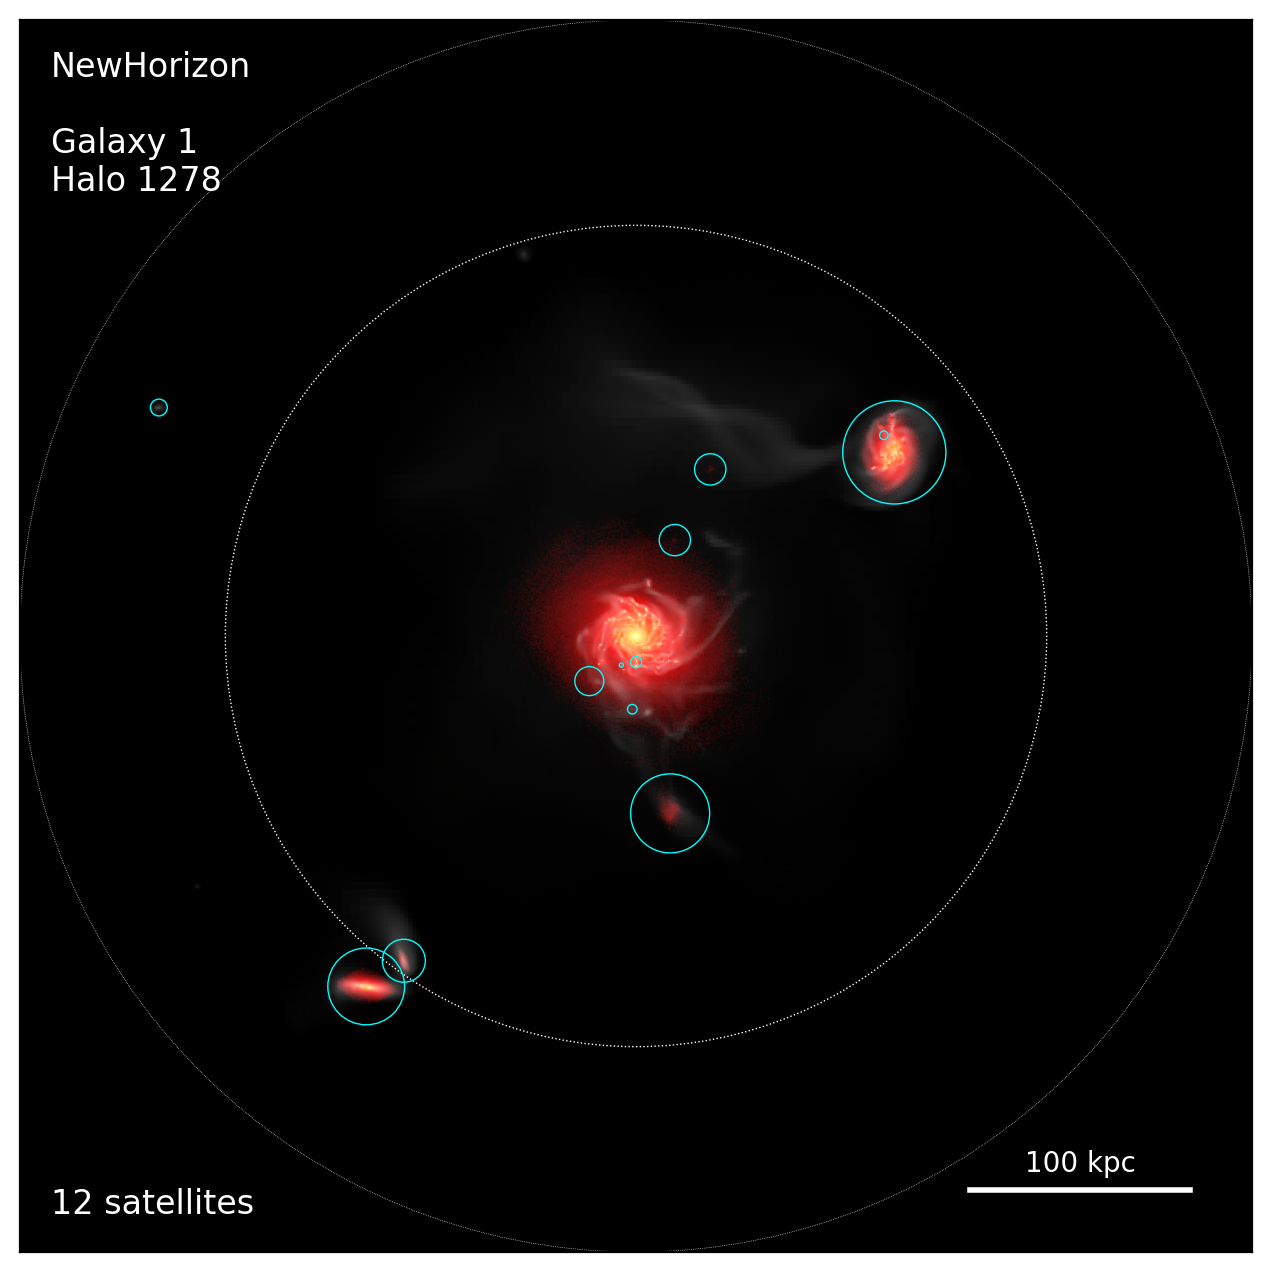

In [319]:
fig, ax = fancy_axis(figsize=(8,8), dpi=200)

snap1.set_box_halo(MWA, 1.5, radius_name='r200_code')
ax.imshow(composite, origin='lower', extent=snap1.box[:2].flatten(), aspect='equal')
cir = plt.Circle((MWA['halo_x'], MWA['halo_y']), MWA['r200_code'], color='w', fill=False, lw=0.5, ls=':')
ax.add_artist(cir)
cir = plt.Circle((MWA['halo_x'], MWA['halo_y']), 1.5*MWA['r200_code'], color='w', fill=False, lw=0.25, ls=':')
ax.add_artist(cir)
cmap = plt.cm.cool_r
norm = plt.Normalize(vmin=0, vmax=1)

ngal = 0
realsats = None
for val in values:
    if(not val['Sat'] in gal_takes.keys()): continue
    take_scos = gal_takes[val['Sat']]
    take_sco = 2 * np.median(take_scos%1)
    sat = gal1s[val['Sat']-1]
    dist = distance(sat, MWA['halo_x'], MWA['halo_y'], MWA['halo_z'])
    if(dist > (1.5*MWA['r200_code'] + sat['r'])): continue
    if(take_sco < 0.3): continue
    cir = plt.Circle((sat['x'], sat['y']), sat['r'], color='cyan', fill=False, lw=0.5, ls='-')
    ax.add_artist(cir)
    ngal += 1
    realsats = sat if(realsats is None) else np.hstack((realsats, sat))

add_scalebar(ax, snap1.unit_l)
addtext(f"{ngal} satellites",ax=ax, loc='lower left', color='white', fontsize=12, offset=0.025)
addtext(f"NewHorizon\n\nGalaxy {target_id}\nHalo {target_hid}",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025)

## All pairs

In [408]:
test = [True]
if(isinstance(test, bool)):
    print( type(test) )
    test=[test]
test, True in test

([True], True)

In [400]:
cmap_star = drawer.make_cmap([(0,0,0),(1,0,0),(1,1,0),(1,1,1)], position=[0,0.4,0.8,1])
composite = painter.composite_image(
    [starmap, cellmap, dmmap], 
    cmaps=[cmap_star, cmr.neutral, cmr.sapphire],
    qscales=[4.5,4,2.5],
    mode='screen',
    vmaxs = [np.nanmax(starmap)*0.9, np.nanmax(cellmap)*10, np.nanmax(dmmap)*1.2]
    )

In [401]:
def point_in_sphere(point, sphere, rname='r', factor=1):
    dist = distance(point, sphere['x'], sphere['y'], sphere['z'])
    return dist < sphere[rname]*factor

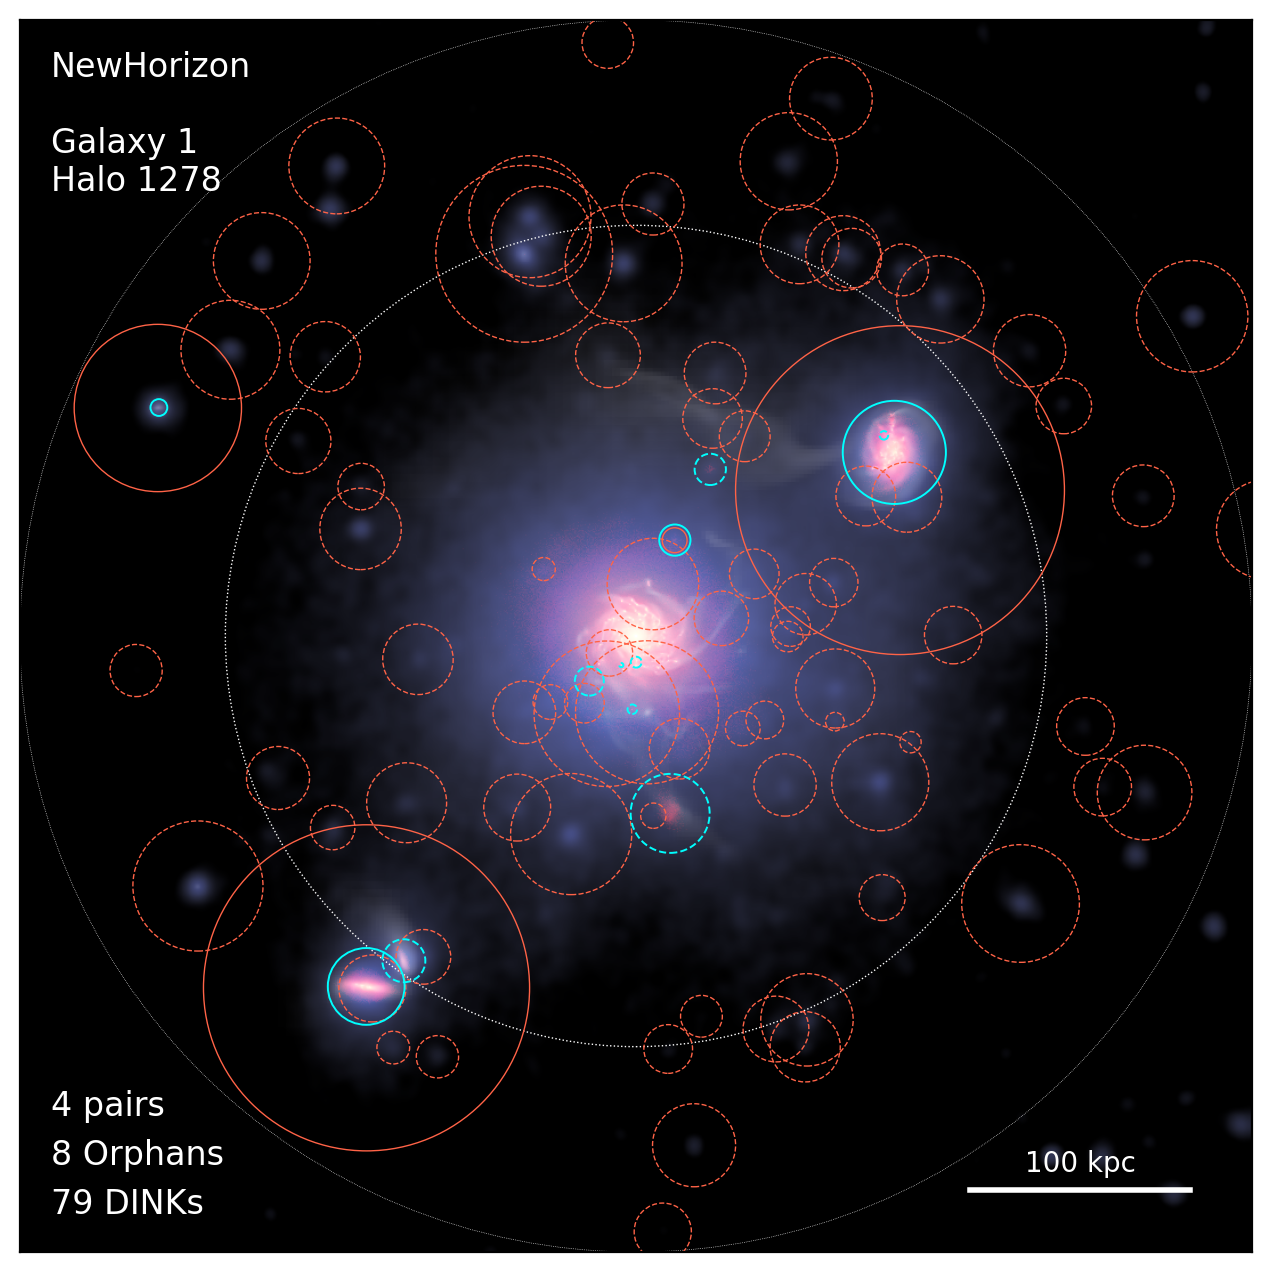

In [402]:
fig, ax = fancy_axis(figsize=(8,8), dpi=200)

snap1.set_box_halo(MWA, 1.5, radius_name='r200_code')
ax.imshow(composite, origin='lower', extent=snap1.box[:2].flatten(), aspect='equal')
cir = plt.Circle((MWA['halo_x'], MWA['halo_y']), MWA['r200_code'], color='w', fill=False, lw=0.5, ls=':')
ax.add_artist(cir)
cir = plt.Circle((MWA['halo_x'], MWA['halo_y']), 1.5*MWA['r200_code'], color='w', fill=False, lw=0.25, ls=':')
ax.add_artist(cir)
cmap = plt.cm.bwr
norm = plt.Normalize(vmin=0, vmax=1)


pairthis = pairs['pair']
pairthis = np.array([[pair[0],pair[1]] for pair in pairthis])
npair = 0
for sub in realsubs:
    ls = '--'
    inner = point_in_sphere(realsats, sub, rname='r', factor=1)
    if(True in inner):
        cands = realsats[inner]
        for cand in cands:
            inside = point_in_sphere(sub, cand, rname='r', factor=1)
            if(inside):
                ls = '-'
                npair += 1
                break
    # if(sub['id'] in pairthis[:,0]):
    #     arg = np.where(pairthis[:,0] == sub['id'])[0][0]
    #     satid = pairthis[arg,1]
    #     if(satid in realsats['id']):
    #         ls = '-'
    cir = plt.Circle((sub['x'], sub['y']), sub['rvir'], color='tomato', fill=False, lw=0.5, ls=ls)
    ax.add_artist(cir)


for sat in realsats:
    ls = '--'
    inner = point_in_sphere(realsubs, sat, rname='r', factor=1)
    if(True in inner):
        cands = realsubs[inner]
        for cand in cands:
            inside = point_in_sphere(sat, cand, rname='r', factor=1)
            if(inside):
                ls = '-'
                break
    cir = plt.Circle((sat['x'], sat['y']), sat['r'], color='cyan', fill=False, lw=0.7, ls=ls)
    ax.add_artist(cir)

add_scalebar(ax, snap1.unit_l)
addtext(f"{len(realsubs)-npair} DINKs", f"{len(realsats)-npair} Orphans", f"{npair} pairs", ax=ax, loc='lower left', color='white', fontsize=12, offset=0.025, dx=0.04)
addtext(f"NewHorizon\n\nGalaxy {target_id}\nHalo {target_hid}",ax=ax, loc='upper left', color='white', fontsize=12, offset=0.025)

In [361]:
stop()

ValueError: stop!

# Check density slope?

Check properties:  
Current) baryon fraction, density slope, Temperature  
Evolution) Formation epoch, assembly history, orbit, ...  

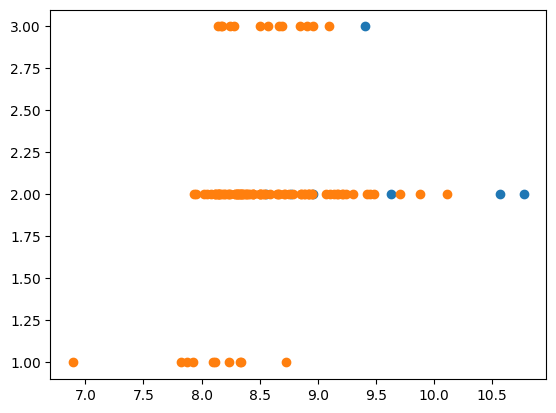

In [ ]:
ind = isin(realhs['id'], hosts)
xval = np.log10( realhs['mvir'] )
yval = realhs['level']
plt.scatter(xval[ind], yval[ind])
plt.scatter(xval[~ind], yval[~ind])

In [375]:
vad[vad['Host']==11]['Sat']

array([  21,  210,  326,  513,  660,  870, 1039, 1114, 1866, 1867, 1868,
       1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 2083,
       3057, 3058, 3059], dtype=int32)

In [383]:
result1s[8]['r200_code']/snap1.unit['kpc']

7.379791569495248

In [384]:
MWA.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200', '<f8'), ('m200', '<f8'), ('r200_code', '<f8'), (